1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

There are 100 global minima and the function value at those points is -1.0316284534838287


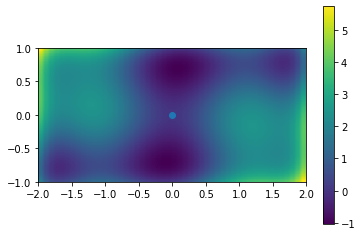

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import pylab

def sh_camelback(x0):
    x = x0[0]
    y = x0[1]
    return (4 - 2.1*(x*x) + (x*x*x*x)/3.0)*(x*x) + x*y + (-4 + 4*(y*y))*(y*y)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)

x0 = [x, y]

minima = optimize.minimize(sh_camelback, x0)
print(f"There are {len(minima.x)} global minima and the function value at those points is {minima.fun}")

or_min = optimize.minimize(sh_camelback, x0=[0, 0])

xcord, ycord = np.meshgrid(x, y)

plt.figure()
plt.imshow(sh_camelback([xcord, ycord]), extent=[-2, 2, -1, 1])
plt.colorbar()
plt.scatter(or_min.x[0], or_min.x[1])

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0, 0.5, 'Min and Max temperatures')

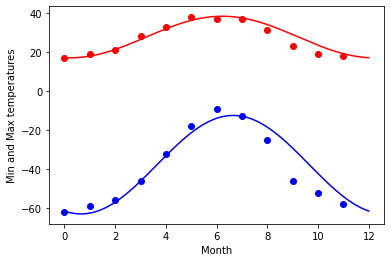

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(12)

def temperature(months, temp, amplitud, offset):
    return (temp + amplitud * np.cos((months + offset) * 2 * np.pi / months.max()))

max_result, cov_max = optimize.curve_fit(temperature, months, max_temp, [20, 10, 0])
min_result, cov_min = optimize.curve_fit(temperature, months, min_temp, [-40, 20, 0])

days = np.linspace(0, 12, num=365)
plt.figure()
plt.plot(max_temp, 'ro')
plt.plot(days, temperature(days, *max_result), 'r-')
plt.plot(min_temp, 'bo')
plt.plot(days, temperature(days, *min_result), 'b-')
plt.xlabel('Month')
plt.ylabel('Min and Max temperatures')

#Yes the fit seems reasonable
#No the time offset is different for max and min temperatures

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [3]:
import pickle
import pandas as pd

file = './data/residuals_261.pkl'

infile = open(file, 'rb')
new_dict = pickle.load(infile)
infile.close()

print(new_dict)

#I wasn't able to retrieve any data from this .pkl file

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

The average of Munich temperatures is 8.933222104668378 Cº
The average coldest temp is -9.955183583035511 and the average hottest temp is 12.313405907403324
F-test between the f(x) and g(x):
CL: 0.000 , additional parameter necessary: YES


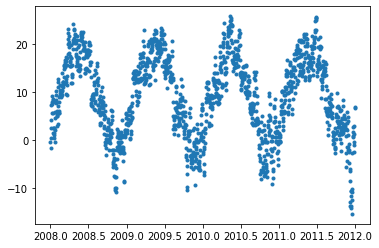

In [42]:
from scipy import stats

filename = './data/munich_temperatures_average_with_bad_data.txt'
date, temperature = np.loadtxt(filename, unpack=True)
keep = np.abs(temperature) < 90
date = date[keep]
temperature = temperature[keep]
def cos1(x, a, b, c):
    return a * np.cos(2 * np.pi * x + b) + c

popt, pcov = optimize.curve_fit(cos1, date, temperature)
y1 = cos1(temperature, popt[0], popt[1], popt[2])
ssr_1 = np.sum((y1 - temperature)**2)
ndof_1 = 3 - 1
mean = np.mean(temperature)


fig, ax = plt.subplots()
xfine1 = np.linspace(1995, 2014, 100)
xfine2 = np.linspace(2008, 2012, 1451)
ax.plot(xfine2, temperature[4754:6205], '.')
#ax.plot(xfine1, cos1(xfine, *popt), color='red')

print(f'The average of Munich temperatures is {mean} Cº')
print(f'The average coldest temp is {popt[0]} and the average hottest temp is {popt[1]}')

def cos2(x, a, b, c, d):
    return a * np.cos(2 * np.pi * b * x + c) + d

popt2, popv2 = optimize.curve_fit(cos2, date, temperature)
y2 = cos2(temperature, popt2[0], popt2[1], popt2[2], popt2[3])
ssr_2 = np.sum((y2 - temperature)**2)
ndof_2 = 4 - 1


def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("F-test between the f(x) and g(x):")
f_test = Ftest(ssr_1, ssr_2, ndof_1, ndof_2, len(temperature), verbose=True)
